In [29]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 
import os
genSavePath = f"{os.getcwd()}/SavedResults/"
day = "17" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 27
repetitionName =  "torchTest"#  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBest*")

saveTop = False
if saveTop:
    saveTopName = "top3udrli.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.1
print(len(savedResults))
print(len(savedResults)/9)

27
3.0


In [30]:
import pandas as pd
from array import ArrayType
from requests import delete
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0

currSeed = 0
currSubj = 0
combinationList = []

testInfoPerSubject = [None] * 10

results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
    
for subject in results:
    currSubj = subject[1]
    testInfoPerSubject[currSubj] = subject[0]
soloFeatures = []
featCombos = []
kernels = testInfoPerSubject[1][2][0]
regValues = testInfoPerSubject[1][2][1]
paradigmName = testInfoPerSubject[1][3]
for subinfo in testInfoPerSubject[1:]:
    if subinfo is None:
        continue
    subSoloFeatures = subinfo[0]
    subfeatCombos = subinfo[1]
    if len(soloFeatures) < len(subSoloFeatures):
        soloFeatures = subSoloFeatures
    if len(featCombos) < len(subfeatCombos):
        featCombos = subfeatCombos
    #print(subinfo)
allCombinations = []
comboNumber = 0
combinationDict = dict()
for featCombo in featCombos:
    for kernel in kernels:
        for regValue in regValues:
            allCombinations.append([featCombo, kernel, regValue, comboNumber])
            combinationDict[f"{featCombo},{kernel},{regValue}"] = comboNumber
            comboNumber = comboNumber + 1
#print(combinationDict)
nrOfCombination = len(allCombinations)
combinationResult = np.zeros([subjectAmount, len(allCombinations), 2])
nrOfSeedsPerSubject = np.zeros(subjectAmount)
seedCounted = np.zeros([subjectAmount, len(allCombinations), (len(savedResults)//9)+1])
currSeed = -1
for s, subject in enumerate(results):
    currSubj = 0
    
    subjectBestArray = np.empty([len(subject)], dtype=object)

    
    currSubj = subject[1]
    if currSubj == 1:
        currSeed = currSeed + 1 
    testInfoPerSubject[currSubj] = subject[0]
    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 6:

                aName = aResults2[0]
                ares = aResults2[1]

                # if type(ares) is tuple:
                #     ares = ares[0]
                # if ares > 0.98:
                #     ares = 0.99
                akernel = aResults2[2]
            
                aC = aResults2[3]
                if seedCounted[currSubj, combinationDict[f"{aName},{akernel},{aC}"], currSeed] == 1:
                    continue
                seedCounted[currSubj, combinationDict[f"{aName},{akernel},{aC}"], currSeed] = 1
                combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] = [int(combinationDict[f"{aName},{akernel},{aC}"]), 
                                                                                           combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][1] + ares]
               

for subNr, subj in enumerate(combinationResult[1:], 1):
    combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]
    if "adaBoost" in kernels:
        combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / 2

headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
topPerFeature = np.zeros([10, len(featCombos)])

lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
    
            cmbNr = int(res[0])

            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
            comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
            nrOfSubjects[cmbNr] += 1
            subjectResultArray[subNr, cmbNr] = res[1]
            comboName = allCombinations[cmbNr][0]

            nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
            
   
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()
                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
        
        
        
# Print the table!
comboAverage = comboAverage / nrOfSubjects
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




/tmp/ipykernel_48629/1082744460.py:162: RuntimeWarning: invalid value encountered in true_divide
  comboAverage = comboAverage / nrOfSubjects


,0,6,7,8,9,10,11,12,13,14,15,16,17,18,24,25,26,27,28,29,30,31,32,33,34,35,36,42,43,44,45,46,47,48,49,50,51,52,53,54,60,61,62,63,64,65,66,67,68,69,70,71,72,78,79,80,81,82,83,84,85,86,87,88,89
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,0.216667,0.183333,0.183333,0.2,0.158333,0.166667,0.166667,0.2,0.183333,0.216667,0.2,0.216667,0.208333,0.266667,0.208333,0.216667,0.216667,0.216667,0.216667,0.216667,0.25,0.25,0.225,0.216667,0.225,0.216667,0.658333,0.658333,0.658333,0.691667,0.683333,0.683333,0.683333,0.666667,0.691667,0.7,0.666667,0.666667,0.658333,0.508333,0.475,0.475,0.525,0.508333,0.508333,0.508333,0.566667,0.558333,0.558333,0.516667,0.491667,0.491667,0.608333,0.616667,0.641667,0.641667,0.625,0.625,0.625,0.7,0.7,0.691667,0.641667,0.625,0.616667
2,0.111111,0.118056,0.118056,0.145833,0.173611,0.173611,0.173611,0.138889,0.180556,0.125,0.152778,0.159722,0.173611,0.152778,0.152778,0.152778,0.138889,0.138889,0.138889,0.145833,0.152778,0.152778,0.173611,0.180556,0.1875,0.201389,0.472222,0.465278,0.486111,0.555556,0.513889,0.506944,0.506944,0.458333,0.479167,0.493056,0.5,0.458333,0.395833,0.4375,0.375,0.375,0.409722,0.402778,0.395833,0.395833,0.479167,0.486111,0.520833,0.506944,0.472222,0.465278,0.451389,0.458333,0.444444,0.444444,0.458333,0.472222,0.458333,0.451389,0.444444,0.458333,0.430556,0.423611,0.395833
3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.111111,0.111111,None,None,None,None,None,None,None,None,None,None,0.25,0.240741,0.240741,0.25,0.240741,0.240741,0.240741,0.240741,0.240741,0.240741,0.231481,0.231481,0.231481,0.231481,0.175926,0.185185,0.203704,0.203704,0.203704,0.203704,0.185185,0.231481,0.203704,0.203704,0.203704,0.203704,0.194444,0.240741,0.240741,0.231481,0.212963,0.222222,0.222222,0.240741,0.240741,0.240741,0.203704,0.203704,0.194444
4,None,0.104167,0.104167,None,None,None,None,None,None,None,None,0.111111,0.104167,0.111111,None,None,None,0.118056,0.118056,0.118056,0.125,0.125,0.118056,0.125,0.111111,0.118056,0.243056,0.243056,0.243056,0.277778,0.256944,0.256944,0.256944,0.229167,0.270833,0.270833,0.236111,0.25,0.243056,0.208333,0.215278,0.222222,0.215278,0.222222,0.222222,0.222222,0.236111,0.236111,0.201389,0.201389,0.222222,0.222222,0.208333,0.222222,0.229167,0.215278,0.229167,0.222222,0.222222,0.236111,0.229167,0.215278,0.222222,0.222222,0.222222
5,0.111111,None,None,0.111111,0.118056,0.104167,0.104167,0.131944,0.131944,0.111111,0.104167,0.118056,0.118056,None,None,None,None,None,None,None,None,None,None,None,None,None,0.236111,0.208333,0.222222,0.243056,0.236111,0.243056,0.243056,0.194444,0.229167,0.243056,0.229167,0.215278,0.208333,0.201389,0.180556,0.180556,0.180556,0.180556,0.1875,0.180556,0.1875,0.1875,0.201389,0.194444,0.194444,0.1875,0.1875,0.1875,0.215278,0.208333,0.208333,0.215278,0.208333,0.208333,0.208333,0.208333,0.222222,0.229167,0.215278
6,0.159091,0.166667,0.166667,0.19697,0.189394,0.19697,0.19697,0.143939,0.174242,0.174242,0.181818,0.151515,0.174242,0.136364,0.136364,0.136364,None,0.106061,0.113636,0.113636,0.151515,0.151515,0.136364,0.113636,None,0.113636,0.454545,0.462121,0.462121,0.462121,0.462121,0.462121,0.462121,0.477273,0.492424,0.477273,0.454545,0.44697,0.454545,0.401515,0.371212,0.378788,0.44697,0.393939,0.386364,0.386364,0.469697,0.477273,0.454545,0.44697,0.416667,0.401515,0.393939,0.454545,0.484848,0.484848,0.416667,0.393939,0.393939,0.492424,0.492424,0.492424,0.477273,0.416667,0.409091
7,0.1875,0.173611,0.173611,0.1875,0.159722,0.159722,0.159722,0.1875,0.173611,0.173611,0.208333,0.166667,0.180556,0.194444,0.180556,0.180556,0.138889,0.138889,0.138889,0.138889,0.138889,0.138889,0.166667,0.159722,0.173611,0.159722,0.465278,0.458333,0.458333,0.458333,0.444444,0.444444,0.444444,0

In [31]:
pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
table = pd.DataFrame(topPerFeature, columns=featCombos)
display(table)


,fftData,fftData_CV,fftData_BC,fftData_BC_CV,fftData_CV_BC
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.216667,0.266667,0.700000,0.566667,0.700000
2,0.180556,0.201389,0.555556,0.520833,0.472222
3,0.000000,0.111111,0.250000,0.231481,0.240741
4,0.111111,0.125000,0.277778,0.236111,0.236111
5,0.131944,0.000000,0.243056,0.201389,0.229167
6,0.196970,0.151515,0.492424,0.477273,0.492424
7,0.208333,0.194444,0.479167,0.444444,0.444444
8,0.183333,0.216667,0.491667,0.475000,0.475000
9,0.236111,0.340278,0.756944,0.597222,0.743056


(5,)



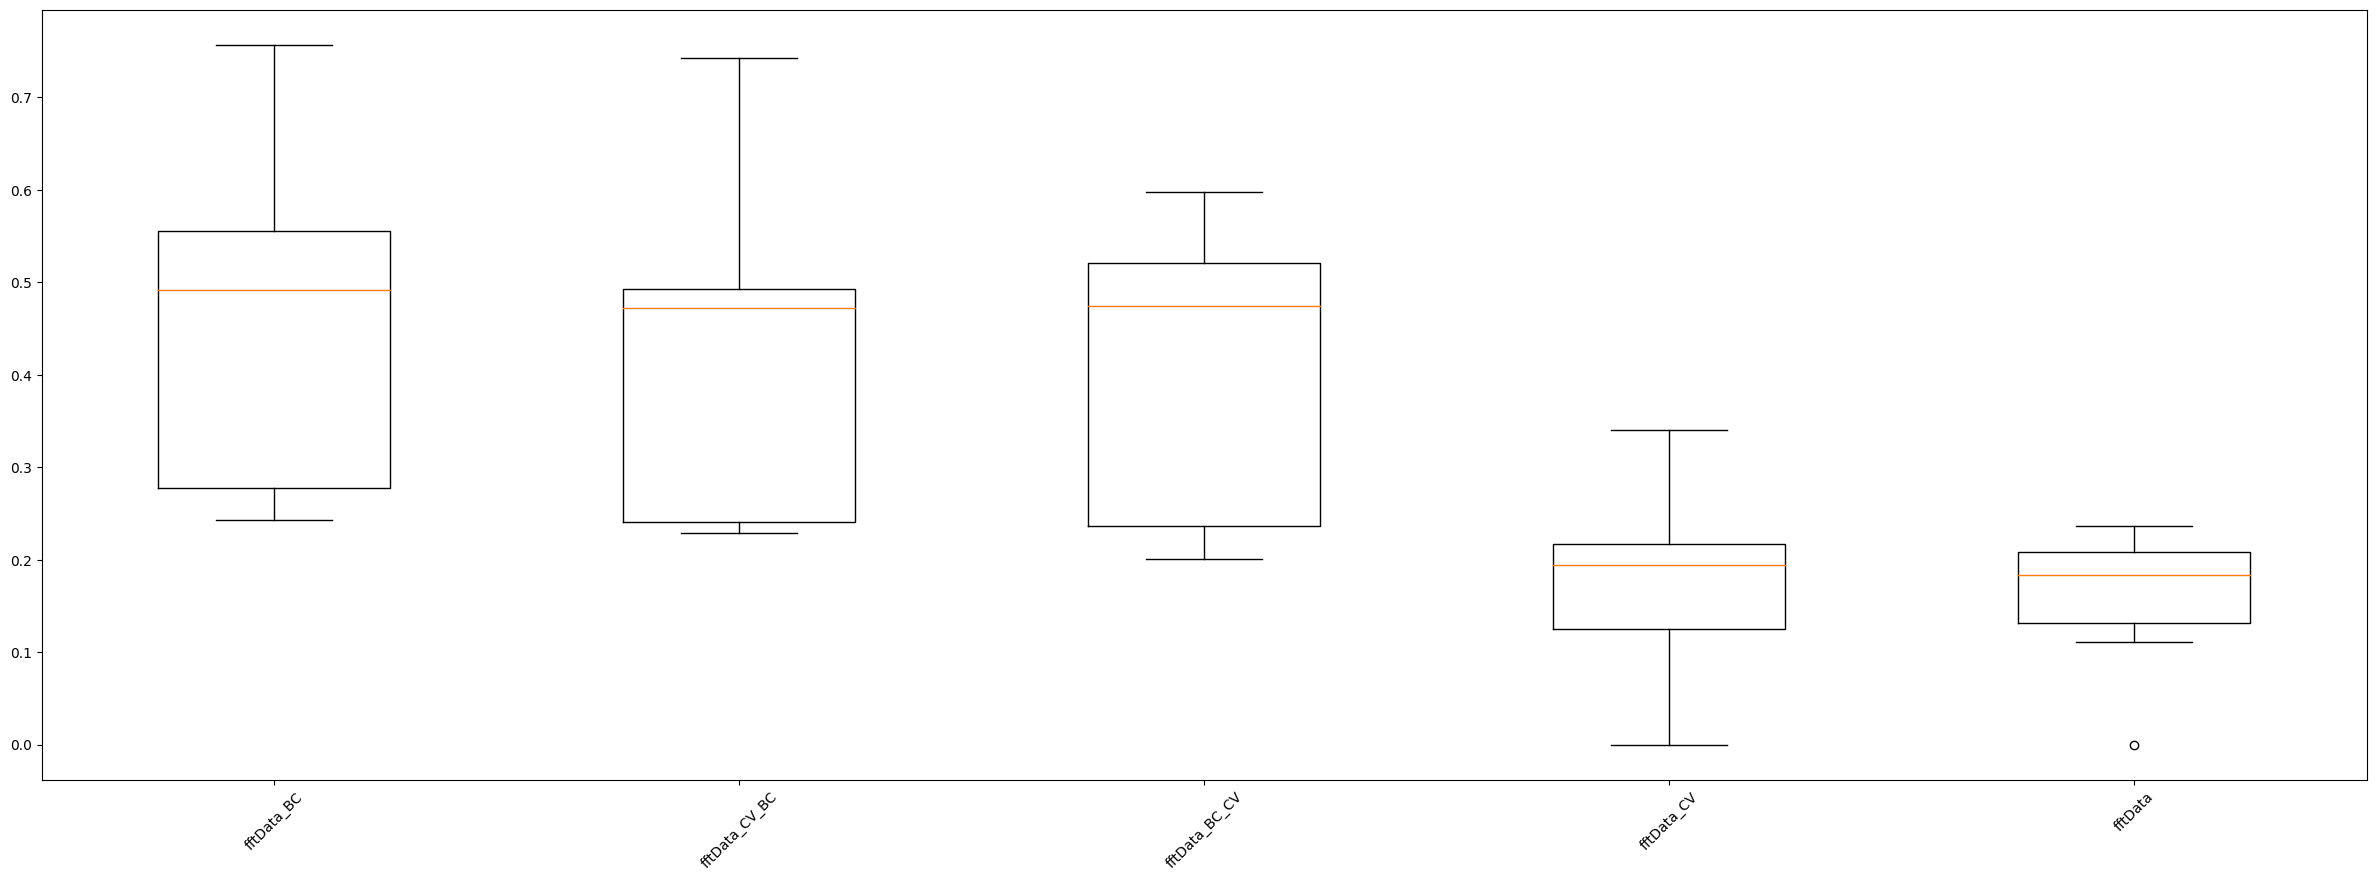

In [32]:
import matplotlib.pyplot as plt
meanTop = np.mean(topPerFeature[1:], axis=0)
indices = np.argsort(meanTop, axis=0)[::-1]

print(indices.shape)
featCombos = np.array(featCombos)

if len(featCombos) < 30:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(len(featCombos[indices][:30]))+1,featCombos[indices][:30],rotation=45)
    print("")
else: 
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(30)+1,featCombos[indices][:30],rotation=90)
    print("")
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:10])
    plt.xticks(np.arange(10)+1,featCombos[indices][:10],rotation=20)
    print("")
    


In [33]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.76 : subject 9, feature:fftData_BC, kernelrbf, C:1.2
Accuracy 0.76 : subject 9, feature:fftData_BC, kernelrbf, C:10
Accuracy 0.76 : subject 9, feature:fftData_BC, kernelrbf, C:5
Accuracy 0.76 : subject 9, feature:fftData_BC, kernelrbf, C:2.5
Accuracy 0.76 : subject 9, feature:fftData_BC, kernelrbf, C:0.5
Accuracy 0.76 : subject 9, feature:fftData_BC, kernelrbf, C:0.1
Accuracy 0.74 : subject 9, feature:fftData_CV_BC, kernelrbf, C:10
Accuracy 0.74 : subject 9, feature:fftData_CV_BC, kernelrbf, C:5
Accuracy 0.74 : subject 9, feature:fftData_CV_BC, kernelrbf, C:2.5
Accuracy 0.74 : subject 9, feature:fftData_BC, kernelsigmoid, C:10


In [34]:
print("Top ten highest accuracies")
for subTop in topThreeAllSubjects:
    subTop.reverse()

Top ten highest accuracies


In [35]:
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects:
    print("")
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )

arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    skip = False  
    
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)



Accuracy 0.76 : subject 9, feature:fftData_BC, kernelrbf, C:1.2

Accuracy 0.7 : subject 1, feature:fftData_CV_BC, kernelsigmoid, C:0.1

Accuracy 0.56 : subject 2, feature:fftData_BC, kernelrbf, C:1.2

Accuracy 0.49 : subject 6, feature:fftData_CV_BC, kernelsigmoid, C:0.1

Accuracy 0.49 : subject 8, feature:fftData_BC, kernelsigmoid, C:10

Accuracy 0.48 : subject 7, feature:fftData_BC, kernelsigmoid, C:0.1

Accuracy 0.28 : subject 4, feature:fftData_BC, kernelrbf, C:1.2

Accuracy 0.25 : subject 3, feature:fftData_BC, kernelrbf, C:1.2

Accuracy 0.24 : subject 5, feature:fftData_BC, kernelrbf, C:5
[array(['fftData_BC', 'fftData_BC', 'fftData_BC'], dtype=object), array(['fftData_BC', 'fftData_BC', 'fftData_BC'], dtype=object), array(['fftData_BC', 'fftData_BC', 'fftData_BC'], dtype=object), array(['fftData_BC', 'fftData_BC', 'fftData_BC'], dtype=object), array(['fftData_BC', 'fftData_BC', 'fftData_BC'], dtype=object), array(['fftData_BC', 'fftData_BC', 'fftData_BC'], dtype=object), array(

In [36]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])



[0.         0.45012821 0.33568376 0.2163505  0.20060273 0.18763889
 0.33249158 0.3267094  0.35026042 0.49391026]


,0,6,7,8,9,10,11,12,13,14,15,16,17,18,24,25,26,27,28,29,30,31,32,33,34,35,36,42,43,44,45,46,47,48,49,50,51,52,53,54,60,61,62,63,64,65,66,67,68,69,70,71,72,78,79,80,81,82,83,84,85,86,87,88,89
0,0.16618,0.150198,0.150198,0.168013,0.156025,0.155519,0.155519,0.161039,0.170328,0.15763,0.175577,0.163557,0.165704,0.197655,0.174838,0.176028,0.196111,0.175072,0.176154,0.177146,0.193074,0.193074,0.190314,0.187266,0.194444,0.181313,0.436925,0.440904,0.444762,0.463384,0.453096,0.45217,0.451244,0.436569,0.451833,0.454162,0.441503,0.436958,0.431626,0.381444,0.35462,0.357262,0.379396,0.37088,0.368186,0.369267,0.403012,0.408071,0.404003,0.394519,0.384979,0.377123,0.394697,0.416915,0.426146,0.42666,0.419805,0.419851,0.416611,0.441185,0.43887,0.430228,0.411158,0.396399,0.384189


Max average accuracy 0.46338383838383834


In [37]:
print("Based on combAverage")
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    #print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combAverage
fftData_BC
rbf
0.46338383838383834

fftData_BC
sigmoid
0.4541619902731014

fftData_BC
rbf
0.45309577254021705

fftData_BC
rbf
0.45216984661429105

fftData_BC
sigmoid
0.45183314627759075



In [38]:
print("Based on combTotal")
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combTotal
fftData_BC
rbf
0.46338383838383834

fftData_BC
sigmoid
0.4541619902731014

fftData_BC
rbf
0.45309577254021705

fftData_BC
rbf
0.45216984661429105

fftData_BC
sigmoid
0.45183314627759075



In [39]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )
    print(allCombinations[maxInd2][0])
    print(allCombinations[maxInd2][1])
    print(f"C: {allCombinations[maxInd2][2]} ")


,0,6,7,8,9,10,11,12,13,14,15,16,17,18,24,25,26,27,28,29,30,31,32,33,34,35,36,42,43,44,45,46,47,48,49,50,51,52,53,54,60,61,62,63,64,65,66,67,68,69,70,71,72,78,79,80,81,82,83,84,85,86,87,88,89
0,1.163258,1.051389,1.051389,1.008081,1.092172,1.088636,1.088636,1.127273,1.192298,1.103409,1.22904,1.30846,1.325631,1.383586,1.223864,1.232197,0.980556,1.225505,1.233081,1.240025,1.351515,1.351515,1.332197,1.310859,1.166667,1.269192,3.932323,3.96814,4.002862,4.170455,4.077862,4.069529,4.061195,3.929125,4.066498,4.087458,3.973527,3.932618,3.884638,3.432997,3.191582,3.215362,3.414562,3.337921,3.313678,3.323401,3.627104,3.672643,3.636027,3.550673,3.464815,3.394108,3.552273,3.752231,3.835311,3.839941,3.778241,3.778662,3.749495,3.970665,3.949832,3.872054,3.700421,3.567593,3.457702


44
9.0
Max total significant accuracy then averaged 0.46338383838383834 
fftData_CV
rbf
C: 10 


In [40]:
for names in featCombos:
    print(names)



fftData
fftData_CV
fftData_BC
fftData_BC_CV
fftData_CV_BC
